In [42]:
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

Thank you to Joomi K. for offering this tutorial. https://joomik.github.io/abtesting/

This is a fictional study that looked at whether the order of teaching the alphabet in kindergarten made a difference in readin test scores.

Students were split into two classes; in class A, the alphabet was taught from **Z to A** before taking a reading test. In class B, the alphabet was taught from **A to Z** before taking the same reading test. Some teachers and alphabet pundits have hypothesized that the second method would be better at teaching young students to read; we looked at the evidence with this study.

Note: Every attempt was made to control for all other variables in the two classes; most importantly, they had the same teacher, textbook, and access to materials. Students were randomly placed into each class. However, there were a few things that could not be controlled for- notably, the two classes met on different times of the week.

**Generate fictional grades on the reading test**

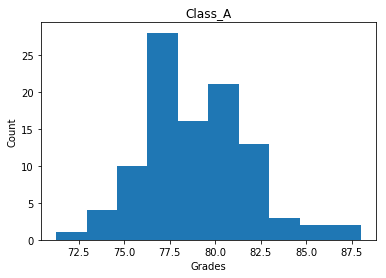

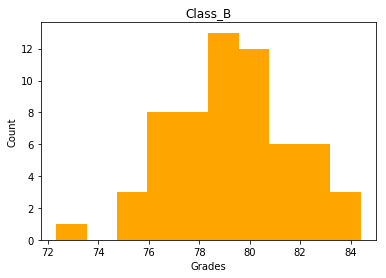

In [43]:
# We chose Normal distribution just to generate data
np.random.seed(seed=233423)
class_A = pm.Normal.dist(mu=79, sd=3).random(size=100)
plt.hist(class_A)
plt.title("Class_A")
plt.xlabel("Grades")
plt.ylabel("Count")
plt.show()

# We chose Normal distribution just to generate data
np.random.seed(seed=224527)
class_B = pm.Normal.dist(mu=79.5, sd=2.5).random(size=60)    # use (mu=79.5, sd=11)
plt.hist(class_B, color='orange')
plt.title("Class_B")
plt.xlabel("Grades")
plt.ylabel("Count")
plt.show()

In [44]:
my_dict = dict( groupA = class_A, groupB = class_B )
df = pd.DataFrame.from_dict(my_dict, orient='index')
df= df.transpose()
df.head()

,groupA,groupB
0,76.871611,77.424102
1,80.354925,81.750720
2,79.650663,78.781196
3,86.766416,80.261404
4,81.837726,77.020525


In [45]:
df.describe()

,groupA,groupB
count,100.000000,60.000000
mean,78.932107,79.337243
std,2.884662,2.417288
min,71.266440,72.324152
25%,77.185180,77.963342
50%,78.533433,79.352594
75%,80.548413,80.793412
max,87.988389,84.394339


Class A had 100 students while class B had 60, and the mean for class B (77.6) is 1.2 points lower than the mean for class A (78.8). We can also see that class B’s standard deviation and maximum grade were lower than class B's standard deviation and maximum. 

How significant are these differences? We'll use Bayesian statistics to estimate the difference in the scores between the two classes, and estimate the uncertainty.

We will also use Bayesian statistics and Pymc3 to ananlyze the probability that teaching the alphabet one way is better than the other.

**P(true_parameters | observed_data) = P(observed_data | true_parameters)*P(true_parameters)**

# Sampling from the Posterior

To pick a distribution that best fits our data we need to ask ourselves:
* are the data values discrete or continuous
* the support of the variable (are the values positive, negative, 0-1 interval, etc.)
* relevant prior information (does research tell us that test scores in reading usually follow a particular distribution?)

In our case, when choosing a prior distribution for our data, we know:
* the values are continuous, so we have to use a continuous distribution
* they are positive between 0 to 100, and grades cannot be negative
* we have no prior research on the matter, so we'll use only the top two criteria

Knowing this, let's use a **T-distribution** (this is less sensitive to outliers compared to the normal distribution) to describe the test scores.

It has 3 parameters: pm.StudentT.dist(nu, mu, sd) also known as: v, mean, standard deviation


**The Mean**

We'll set the mean as the pooled empirical mean of the data, and 2 times the pooled empirical standard deviation. This applies very “diffuse” information to these quantities when using a normal distribution.

In [46]:
μ_m = np.append(class_A, class_B).mean()              # also known as a hyperparameter
μ_s = (np.append(class_A, class_B).std()) * 2         # also known as a hyperparameter

with pm.Model() as model:
    """
    The priors for the mean.
    """
    class_A_mean = pm.Normal('class_A_mean', μ_m, sd=μ_s)
    class_B_mean = pm.Normal('class_B_mean', μ_m, sd=μ_s)

Below, is a sample distribution of our possible values for the prior mean, given the chosen hyperparameters above.

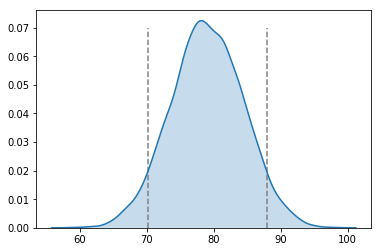

Given our hyperparameters in the model, 90% of the mean of classes A or B should fall between 70.17 to 88.00

Without knowing the 'true' mean, this range seems reasonable enough for grades in the subject of reading.


In [47]:
mean_sample =stats.norm.rvs(loc=μ_m,  scale=μ_s, size=10000)
np.random.seed(seed=13)
sns.kdeplot(mean_sample, shade=True)
a = stats.norm.interval(0.9, loc=μ_m, scale=μ_s)      #90% intervals
plt.vlines(a[0], 0, 0.07, linestyle="--", color='gray')
plt.vlines(a[1], 0, 0.07, linestyle="--", color='gray')
plt.show()
print("Given our hyperparameters in the model, 90% of the mean of classes A or B should fall between \
{:0.2f} to {:0.2f}".format(a[0],a[1]))
print("\nWithout knowing the 'true' mean, this range seems reasonable enough for grades in the subject of reading.")

**The Standard Deviation**

We know that the standard deviation of our data is between 4-7 for both classes. However, given that we're not sure how "true" these deviations are (if experiment was repeated an infinite amount of times, what would be the expected value?), we'll choose deviations that are equally likely from 1 to 30. This broad range of deviations represents a non-constrictive prior, allowing the data to really influence the posterior, while the prior will have very little influence. 

* Generally, if you're not sure what the prior parameters should be, you should not allow them to have much influence on the posterior sample.

For this we need a uniform distribution

In [48]:
with model:
    """
    The priors for the standard deviation.
    """
    class_A_std = pm.Uniform('class_A_std', lower=1, upper=30)
    class_B_std = pm.Uniform('class_B_std', lower=1, upper=30)

Below, you will find a sample distribution of our possible values for the prior standard deviation, given the chosen hyperparameters

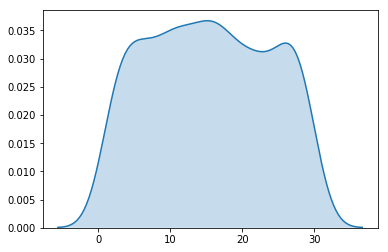

Remember that a uniform distribution means that any number within the distribution is as likely to occur.


In [49]:
np.random.seed(seed=29002)
std_sample = pm.Uniform.dist(lower=1, upper=30).random(size=1000)
sns.kdeplot(std_sample, shade=True)
plt.show()
print("Remember that a uniform distribution means that any number within the distribution is as likely to occur.")

As you can see from the plot above, the standard deviation values from 1 to 30 are almost all equally likely 

**The Degrees of Freedom (v)**

Before we choose a distribution for degrees of freedom, we need to understand how the degrees of freedom might affect a Student-T distribution.
* let's use the mean and std of classB as an exapmle, and draw a Student-T with ν=3 and ν=66

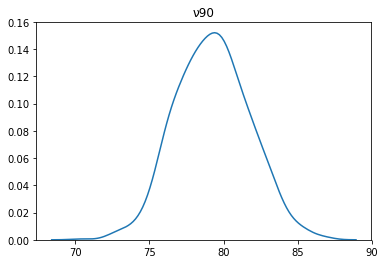

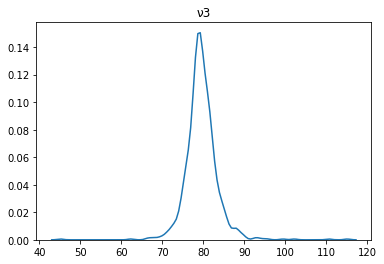

In [50]:
np.random.seed(seed=345)
ν90 = pm.StudentT.dist(nu=90, mu=class_B.mean(), sd=class_B.std()).random(size=1000)
ν3 = pm.StudentT.dist(nu=3, mu=class_B.mean(), sd=class_B.std()).random(size=1000)
sns.kdeplot(ν90)
plt.title("ν90")
plt.show()
sns.kdeplot(ν3)
plt.title("ν3")
plt.show()

Conclusion: the lower the ν, the fatter the tails are.

Thus, if we choose a distribution with ν ranging from 3 to 90, the possible tails of our Student-T would represent data that spans from 65-90 or 45-115. This range of tails should cover the possible outliers in our data reasonably well. Therefore, we need a distribution that can offer us values from 3 to 90.

For the prior of ν, an exponential distribution with mean 29 was selected because it balances near-normal distributions, i.e. thin tails, (where ν > 29) with more thick-tailed distributions (ν < 29). In other words, this spreads credibility fairly evenly over nearly normal or heavy tailed data. Other distributions that could have been used were various uniform distributions, gamma distributions, etc.

In [51]:
with model:
    """
    Prior for ν is an exponential (lambda=29) shifted +1.
    """
    ν = pm.Exponential('ν_min_one', 1/29.) + 1                     # +1 so it's never equal to zero

Below, you will find a sample distribution of our possible values for the prior degrees of freedom, given the chosen hyperparameters

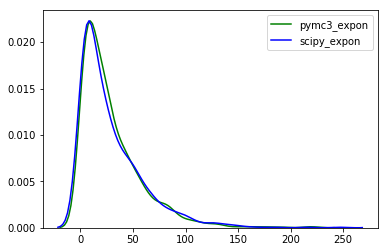

In [52]:
# first, let's find the equivalent of pymc3 expon distribution in scipy
np.random.seed(seed=32)
pymc3_expon = (pm.Exponential.dist(1/29.)).random(size=1000)
sns.kdeplot(pymc3_expon, color='green', label='pymc3_expon')
scipy_expon = (stats.expon.rvs(loc=0, scale=29, size=1000))
sns.kdeplot(scipy_expon, color='blue', label='scipy_expon')
plt.legend()
plt.show()

In [63]:
# sample distribution of our possible values for the prior degrees of freedom
np.random.seed(seed=200343)
ν_sample = stats.expon.rvs(loc=0, scale=29, size=1000) + 1
ν_sample = np.percentile(ν_sample,[5,95])
print("Given the hyperparameters, 90% of the ν's of classes A or B should fall between \
{:0.2f} to {:0.2f}".format(ν_sample[0],ν_sample[1]))
print("\nWe've proven already that when ν=range(3 to 90), it creates possible Student-T tails \
(in this case students' grades) anywhere from 65-90 (ν=90), or 45-115 (ν=3). And these are acceptable ouliers.")

Given the hyperparameters, 90% of the ν's of classes A or B should fall between 2.84 to 92.59

We've proven already that when ν=range(3 to 90), it creates possible Student-T tails (in this case students' grades) anywhere from 65-90 (ν=90), or 45-115 (ν=3). And these are acceptable ouliers.


**The Likelihood: P(observed_data | true_parameters)**

In [54]:
with model:
    """
    Transforming standard deviations to precisions (1/variance) before
    specifying likelihoods, because in pymc3 Student-T we can specify
    standard deviation or lam (precision). Here we choose lam.
    """

    λ1 = class_A_std**-2 # this says lambda1 = \frac{1}{\sigma^2},
    λ2 = class_B_std**-2 # this says lambda2 = \frac{1}{\sigma^2}

    group1 = pm.StudentT('group1', nu=ν, mu=class_A_mean, lam=λ1, observed=class_A)
    group2 = pm.StudentT('group2', nu=ν, mu=class_B_mean, lam=λ2, observed=class_B)

Now we’ll look at the difference between class means and class standard deviations and the total effect size.

There are 3 main types of effect size (http://www.polyu.edu.hk/mm/effectsizefaqs/effect_size_equations2.html):
* **Cohen's d** is the appropriate effect size measure if two groups have similar standard deviations and are of similar size. **Glass' delta**, which uses only the standard deviation of the control group, is an alternative measure if each group has a different standard deviation. **Hedges' g**, which provides a measure of effect size weighted according to the relative size of each sample, is an alternative where there are different sample sizes.
* In our case, since the sample sizes between the two classrooms are different, we will use Hedges' g equation for effect size

In [55]:
"""Hedges' g effect size"""

n_A = len(class_A)
n_B = len(class_B)

with model:
    """
    The effect size is the difference in means/pooled estimates of the standard deviation.
    The Deterministic class represents variables whose values are completely determined
    by the values of their parents.
    """
    
    diff_of_means = pm.Deterministic('difference of means',  class_A_mean - class_B_mean)
    diff_of_stds = pm.Deterministic('difference of stds',  class_A_std - class_B_std)
    HedgesG_effect_size = pm.Deterministic('HedgesG_effect_size',
                                   diff_of_means / np.sqrt(
                                       (((n_A-1)*(class_A_std**2)) + ((n_B-1)*(class_B_std**2))) / (n_A+n_B-2))
                                          )

In [56]:
"""Cohen's d effect size"""

# with model:
#     """
#     The effect size is the difference in means/pooled estimates of the standard deviation.
#     The Deterministic class represents variables whose values are completely determined
#     by the values of their parents.
#     """
    
#     diff_of_means = pm.Deterministic('difference of means',  class_A_mean - class_B_mean)
#     diff_of_stds = pm.Deterministic('difference of stds',  class_A_std - class_B_std)
#     effect_size = pm.Deterministic('effect size',
#                                    diff_of_means / np.sqrt((class_A_std**2 + class_B_std**2) / 2))

"Cohen's d effect size"

In [57]:
with model:
    trace = pm.sample(2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\aschroeder\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [ν_min_one_log__, class_B_std_interval__, class_A_std_interval__, class_B_mean, class_A_mean]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 667.16it/s]


**Summarize the posterior distributions of the parameters.**

In [58]:
pm.summary(trace[1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
class_A_mean,78.857957,0.286084,0.006572,78.288833,79.415839,1971.0,0.999808
class_B_mean,79.338188,0.325450,0.008763,78.680033,79.976287,1549.0,1.000176
class_A_std,2.736104,0.246431,0.006631,2.237646,3.202642,1383.0,0.999517
class_B_std,2.349606,0.259142,0.005995,1.877852,2.880634,2000.0,1.000044
ν_min_one,29.910998,26.482652,0.656924,2.730701,84.247050,1586.0,0.999583
difference of means,-0.480230,0.437959,0.010365,-1.277126,0.400557,1746.0,1.000448
difference of stds,0.386498,0.329371,0.006950,-0.309422,0.982981,2000.0,0.999734
HedgesG_effect_size,-0.186011,0.169417,0.004064,-0.504205,0.147194,1727.0,1.000484


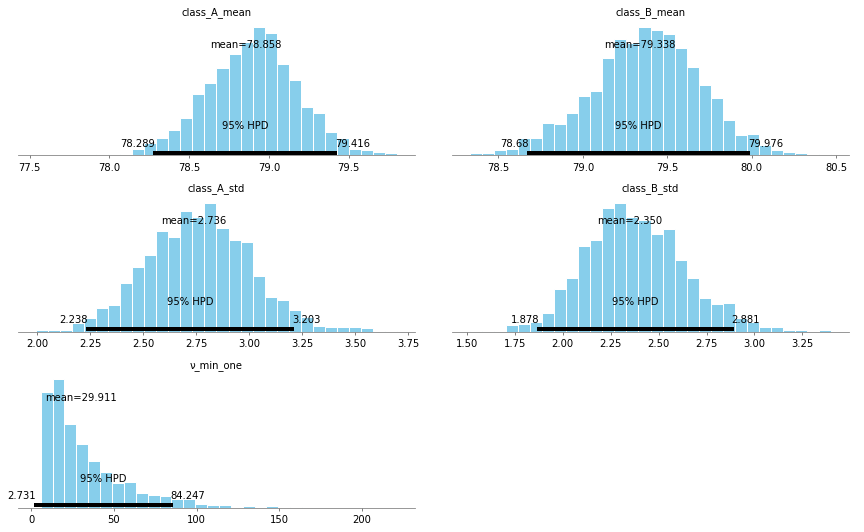

In [60]:
pm.plot_posterior(trace[1000:],
                  varnames=['class_A_mean', 'class_B_mean', 'class_A_std', 'class_B_std', 'ν_min_one'],
                  color='#87ceeb');

* Top left: 95% of the 'true' average grade in class_A falls between 78.3 to 79.4; the mean of those 'true' average grades is 78.8
* mid left: 95% of the 'true' std of grades in class_A falls between 2.2 to 3.2; the mean of those 'true' std is 2.7

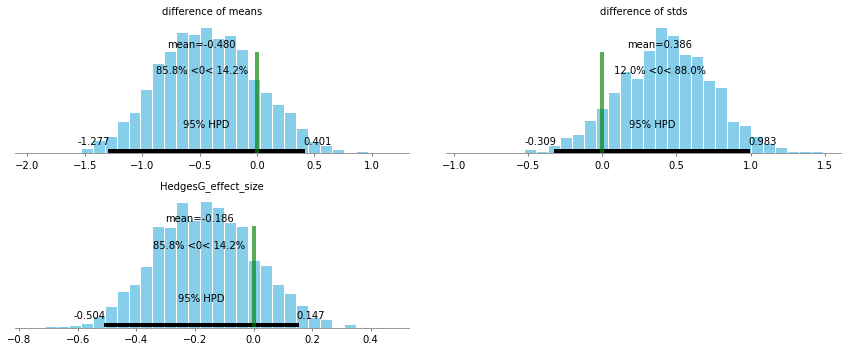

In [20]:
pm.plot_posterior(trace[1000:],
                  varnames=['difference of means', 'difference of stds', 'HedgesG_effect_size'],
                  ref_val=0,
                  color='#87ceeb');

* Top left: There is a 14.2% probability that the 'true' mean of grades in class_A is bigger than that of class_B
* Top right: There is a 88% probability that the 'true' std of grades in class_A is bigger than that of class_B
* Bottom left: There is a 14.2% probability that the 'true' effect of grades in class_A is bigger than that of class_B

It looks like the variability (std) in scores for class_B was somewhat lower than for class_A -- perhaps, switching the order that the alphabet was taught not only increased average of scores, but brought some of the outlier students (particularly the ones that would have scored most poorly) closer to the mean?

**Extra stats/visualizations**

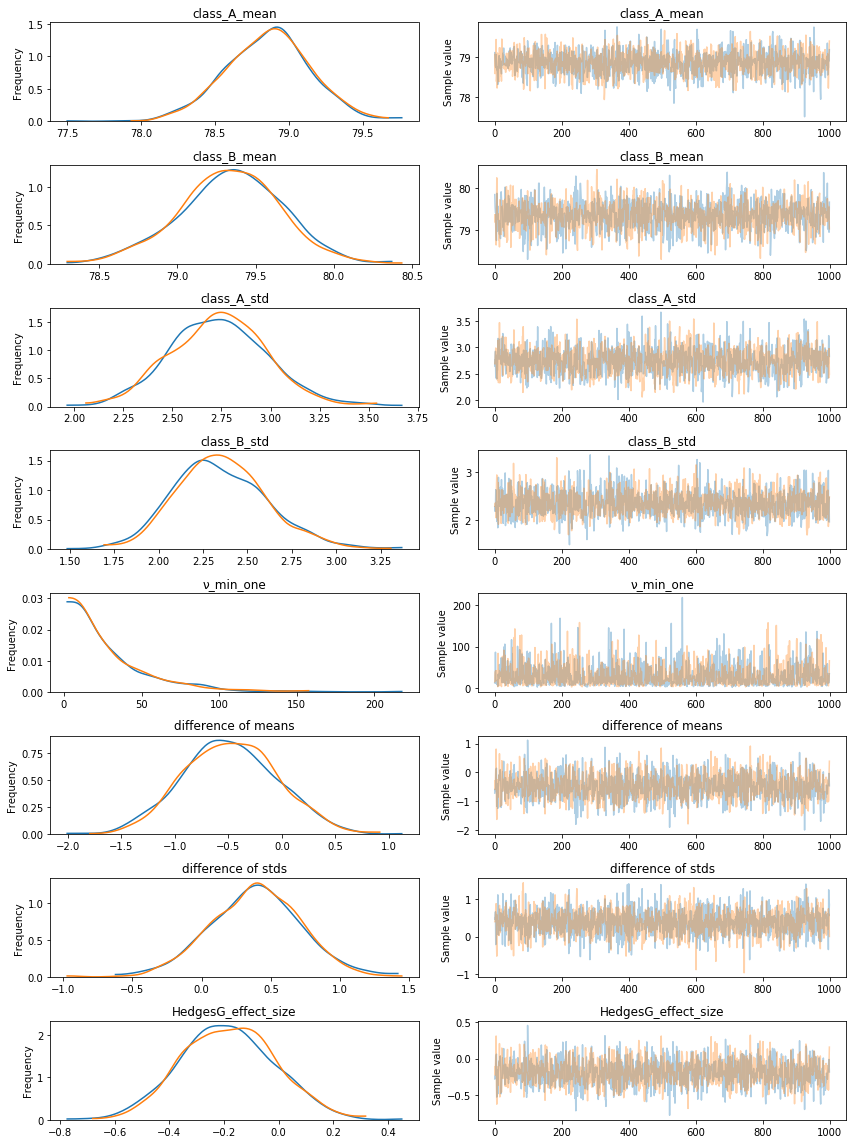

In [61]:
pm.traceplot(trace[1000:])
plt.show()